In [80]:
import pandas as pd # pandas
import numpy as np
import os
import re
from datetime import datetime, timedelta, date

import plotly.express as px

In [81]:
def clean_df(df):
    df['project_id'] = df['Project ID'].fillna(df['Project Code'])
    df['project_id'] = df['project_id'].fillna(df['Unnamed: 0'])
    return df

In [82]:
def get_window_datetimes(file_name):
    file_name = file_name.replace("-", "_")
    re_string = r'\((.*?)\)' # regex string for finding window start and end dates

    match = re.findall(re_string, file_name)
    start = match[0].split("_")
    start_month = int(start[0])
    start_day = int(start[1])
    start_year = int(start[2])
    start_dt = datetime(month=start_month, day=start_day, year=start_year)
    
    end = match[1].split("_")
    end_month = int(end[0])
    end_day = int(end[1])
    end_year = int(end[2])
    end_dt = datetime(month=end_month, day=end_day, year=end_year)
    return start_dt, end_dt

In [83]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# 2019

In [84]:
# define locations of the files we want to use
data_dir = '../data/Spreadsheets_2019/'
time_window_dirs = os.listdir(data_dir) # << a list of the file names in the directory

In [85]:
vimeo_device_dfs = []
vimeo_region_dfs = []
vimeo_video_dfs = []
vimeo_date_dfs = []
vimeo_source_dfs = []

for window_dir in time_window_dirs:
    file_names = os.listdir(data_dir+window_dir)
    for file_name in file_names:
        start_dt, end_dt = get_window_datetimes(file_name)
        if 'Vimeo_Device' in file_name:
            vimeo_device_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_device_df['start'] = start_dt
            vimeo_device_df['end'] = end_dt
            vimeo_device_dfs.append(vimeo_device_df)
        if 'Vimeo_Region' in file_name:
            vimeo_region_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_region_df['start'] = start_dt
            vimeo_region_df['end'] = end_dt
            vimeo_region_dfs.append(vimeo_region_df)
        if 'Vimeo_Video' in file_name:
            video_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            video_df.columns = ['Project ID'] + video_df.columns[1:].to_list() # make the project id column name consistent
            video_df.plays = video_df.plays.replace('\r\n', np.nan)
            video_df = video_df[~video_df.isnull().all(axis=1)] # remove all completely null rows
            video_df['start'] = start_dt
            video_df['end'] = end_dt
            vimeo_video_dfs.append(video_df)
        if 'Vimeo_Date' in file_name:
            vimeo_date_df=pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_date_df['start'] = start_dt
            vimeo_date_df['end'] = end_dt
            vimeo_date_dfs.append(vimeo_date_df)
        if 'Vimeo_Source' in file_name:
            vimeo_source_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_source_df['start'] = start_dt
            vimeo_source_df['end'] = end_dt
            vimeo_source_dfs.append(pd.read_csv(data_dir+window_dir+"/"+file_name))
            
vimeo_device_df = pd.concat(vimeo_device_dfs, axis=0, sort=False)
vimeo_region_df = pd.concat(vimeo_region_dfs, axis=0, sort=False)
vimeo_video_df = pd.concat(vimeo_video_dfs, axis=0, sort=False)
vimeo_date_df = pd.concat(vimeo_date_dfs, axis=0, sort=False)
vimeo_source_df = pd.concat(vimeo_source_dfs, axis=0, sort=False)

In [86]:
covered_datetime_windows = []
for ind, group in vimeo_device_df.groupby(['start','end']):
    covered_datetime_windows.append((ind[0].to_pydatetime().date(), ind[1].to_pydatetime().date()))

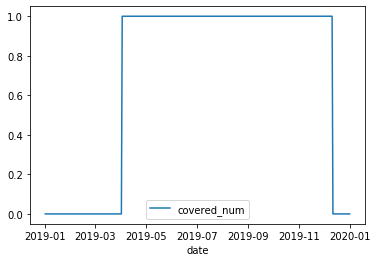

In [87]:
start_date = date(2019, 1, 1)
end_date = date(2020, 1, 1)
covered = []
for single_date in daterange(start_date, end_date):
    coverage = []
    for start,end in covered_datetime_windows:
        coverage.append(start <= single_date <= end)
    covered.append({'date':single_date, 'covered':any(coverage)})
covered_df = pd.DataFrame(covered)
covered_df['covered_num'] = [1 if x else 0 for x in covered_df['covered']]
covered_df.plot(x='date', y='covered_num')

# Get the 28 day windows starting from the first of every year.

In [88]:
vimeo_date_dfs[0].head()

,plays,downloads,loads,finishes,start_date,end_date,likes,comments,unique_loads,mean_percent,mean_seconds,sum_seconds,total_seconds,unique_viewers,start,end
0,209,0.0,1070.0,36.0,2019-11-13,2019-11-14,0.0,0.0,195.0,68.0,304.0,63686.0,102799.0,94.0,2019-11-13,2019-12-10
1,226,0.0,1076.0,40.0,2019-11-14,2019-11-15,1.0,0.0,177.0,68.0,324.0,73276.0,118004.0,81.0,2019-11-13,2019-12-10
2,190,0.0,907.0,37.0,2019-11-15,2019-11-16,0.0,0.0,164.0,66.0,236.0,44989.0,79987.0,83.0,2019-11-13,2019-12-10
3,116,0.0,849.0,14.0,2019-11-16,2019-11-17,0.0,0.0,145.0,53.0,229.0,26621.0,59098.0,58.0,2019-11-13,2019-12-10
4,194,0.0,874.0,34.0,2019-11-17,2019-11-18,0.0,0.0,155.0,59.0,270.0,52490.0,99783.0,71.0,2019-11-13,2019-12-10


# 2018

In [69]:
# define locations of the files we want to use
data_dir = '../data/Spreadsheets_2018/'
time_window_dirs = os.listdir(data_dir) # << a list of the file names in the directory

In [70]:
vimeo_device_dfs = []
vimeo_region_dfs = []
vimeo_video_dfs = []
vimeo_date_dfs = []
vimeo_source_dfs = []

for window_dir in time_window_dirs:
    file_names = os.listdir(data_dir+window_dir)
    for file_name in file_names:
        start_dt, end_dt = get_window_datetimes(file_name)
        if 'Vimeo_Device' in file_name:
            vimeo_device_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_device_df['start'] = start_dt
            vimeo_device_df['end'] = end_dt
            vimeo_device_dfs.append(vimeo_device_df)
        if 'Vimeo_Region' in file_name:
            vimeo_region_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_region_df['start'] = start_dt
            vimeo_region_df['end'] = end_dt
            vimeo_region_dfs.append(vimeo_region_df)
        if 'Vimeo_Video' in file_name:
            video_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            video_df.columns = ['Project ID'] + video_df.columns[1:].to_list() # make the project id column name consistent
            video_df.plays = video_df.plays.replace('\r\n', np.nan)
            video_df = video_df[~video_df.isnull().all(axis=1)] # remove all completely null rows
            video_df['start'] = start_dt
            video_df['end'] = end_dt
            vimeo_video_dfs.append(video_df)
        if 'Vimeo_Date' in file_name:
            vimeo_date_df=pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_date_df['start'] = start_dt
            vimeo_date_df['end'] = end_dt
            vimeo_date_dfs.append(vimeo_date_df)
        if 'Vimeo_Source' in file_name:
            vimeo_source_df = pd.read_csv(data_dir+window_dir+"/"+file_name)
            vimeo_source_df['start'] = start_dt
            vimeo_source_df['end'] = end_dt
            vimeo_source_dfs.append(pd.read_csv(data_dir+window_dir+"/"+file_name))
            
vimeo_device_df = pd.concat(vimeo_device_dfs, axis=0, sort=False)
vimeo_region_df = pd.concat(vimeo_region_dfs, axis=0, sort=False)
vimeo_video_df = pd.concat(vimeo_video_dfs, axis=0, sort=False)
vimeo_date_df = pd.concat(vimeo_date_dfs, axis=0, sort=False)
vimeo_source_df = pd.concat(vimeo_source_dfs, axis=0, sort=False)

IndexError: list index out of range

In [72]:
file_names

['Facebook_Posts_02_08_18_03_07_18.xlsx',
 'Twitter_02_08_2018_03_07_2018.csv',
 'Vimeo_02_08_18_03_07_18.xlsx',
 'Facebook_Pages_02_08_2018_03_07_2018.xls']

In [74]:
df = pd.read_excel(data_dir+window_dir+"/"+file_names[2])

In [75]:
df.head()

,plays,downloads,loads,finishes,start_date,end_date,likes,comments,mean_percent,mean_seconds,sum_seconds,total_seconds
0,490,1.0,1604.0,49.0,2018-02-08,2018-02-09,1.0,0.0,72.0,128.0,62879.0,86751.0
1,455,0.0,1296.0,0.0,2018-02-09,2018-02-10,0.0,0.0,0.0,0.0,0.0,0.0
2,574,0.0,1489.0,0.0,2018-02-10,2018-02-11,5.0,0.0,0.0,0.0,0.0,0.0
3,600,3.0,1490.0,121.0,2018-02-11,2018-02-12,2.0,0.0,67.0,284.0,170624.0,254407.0
4,559,0.0,1590.0,139.0,2018-02-12,2018-02-13,0.0,0.0,69.0,316.0,176998.0,255362.0


,Project ID,plays,downloads,loads,finishes,likes,comments,uri,name,duration,created_time,sizes,unique_loads,mean_percent,mean_seconds,sum_seconds,total_seconds,unique_viewers,start,end
0,BG,942,0.0,39932.0,109.0,1.0,0.0,/videos/189724238,Brown Girls -- Trailer,141.0,2016-11-01T01:03:06+00:00,Array,15724.0,60.0,41.0,39270.0,133678.0,540.0,2019-11-13,2019-12-10
1,BG,562,0.0,2399.0,110.0,1.0,1.0,/videos/203924325,Brown Girls -- Episode 1,410.0,2017-02-14T00:43:46+00:00,Array,1002.0,71.0,250.0,141000.0,230952.0,370.0,2019-11-13,2019-12-10
2,SFP,493,0.0,1150.0,21.0,1.0,0.0,/videos/143933380,Open TV Presents: Southern for Pussy,283.0,2015-10-28T22:38:55+00:00,Array,497.0,36.0,69.0,34114.0,139744.0,314.0,2019-11-13,2019-12-10
3,TRS,378,0.0,776.0,32.0,1.0,0.0,/videos/375475586,The Right Swipe - Episode 2,867.0,2019-11-25T18:26:55+00:00,Array,398.0,61.0,469.0,177449.0,328084.0,244.0,2019-11-13,2019-12-10
4,BG,243,0.0,587.0,70.0,1.0,0.0,/videos/204010747,Brown Girls -- Episode 2,874.0,2017-02-14T14:31:09+00:00,Array,276.0,75.0,599.0,145659.0,212609.0,171.0,2019-11-13,2019-12-10


In [71]:
time_window_dirs

['Spreadsheets (02_08_2018)-(03_07_2018)',
 'Spreadsheets (01_11_2018)-(02_07_2018)',
 'Spreadsheets (06_22_2018)-(07_25_2018)',
 'Spreadsheets (04_04_2018)-(06_21_2018)',
 'Spreadsheets (03_07_2018)-(04_04_2018)',
 'Spreadsheets (08_27_2018)-(10_19_2018)',
 'Spreadsheets (07_26_2018)-(08_26_2018)',
 'Spreadsheets (10_19_2018)-(11_14_2018)']

In [55]:
covered_datetime_windows = []
for ind, group in vimeo_device_df.groupby(['start','end']):
    covered_datetime_windows.append((ind[0].to_pydatetime().date(), ind[1].to_pydatetime().date()))

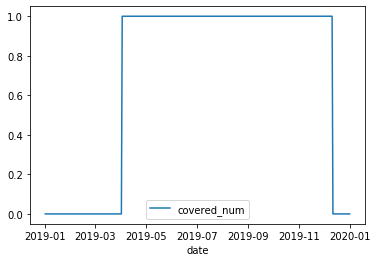

In [67]:
start_date = date(2019, 1, 1)
end_date = date(2020, 1, 1)
covered = []
for single_date in daterange(start_date, end_date):
    coverage = []
    for start,end in covered_datetime_windows:
        coverage.append(start <= single_date <= end)
    covered.append({'date':single_date, 'covered':any(coverage)})
covered_df = pd.DataFrame(covered)
covered_df['covered_num'] = [1 if x else 0 for x in covered_df['covered']]
covered_df.plot(x='date', y='covered_num')